In [1]:
import albumentations as A
import numpy as np
import os
import random
import sys

import torch
import torch.nn.functional as F
import torchvision.transforms as T
from hydra.utils import instantiate
from torch import nn, Tensor

from functools import partial
from omegaconf import DictConfig, OmegaConf
from tqdm.notebook import tqdm
from typing import Any, Callable, Dict, Iterable, List, Tuple

In [2]:
import cv2
import PIL
import kornia

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
BASE_DIR = '/home/dmitry/projects/dfdc'
SRC_DIR = os.path.join(BASE_DIR, 'src')
HDF5_DIR = '/media/dmitry/other/dfdc-crops/hdf5'
IMG_DIR = '/media/dmitry/other/dfdc-crops/webp_lossy'
VID_DIR = '/home/dmitry/projects/dfdc/data/dfdc-videos'

In [5]:
sys.path.insert(0, f'/home/{os.environ["USER"]}/projects/dfdc/vendors/Pytorch_Retinaface')
from layers.functions.prior_box import PriorBox

In [6]:
sys.path.insert(0, SRC_DIR)

In [7]:
from detectors.retinaface import init_detector, prepare_imgs, postproc_detections_gpu
from dataset.transforms import ResizeTensor, SpatialGradFilter, Resize
from video import read_frames_cv2

In [8]:
from predict import merge_detector_cfg
from detection_utils import max_num_faces
from image import crop_square_torch

In [9]:
sys.path.insert(0, './nb_utils')
from visualise import show_images

In [10]:
def find_faces(frames: Tensor, model: torch.nn.Module,
               device: torch.device, conf: Dict[str, Any]) -> List[Tensor]:
    D, H, W, C = frames.shape
    # D, H, W, C -> D, C, H, W
    frames_orig = frames.permute(0, 3, 1, 2)
    frames, scale = prepare_imgs(frames)
    prior_box = PriorBox(conf, image_size=(H, W))
    priors = prior_box.forward().to(device)
    scale = scale.to(device)

    chunk_size = conf["batch_size"]
    detections = []
    for start in range(0, D, chunk_size):
        end = start + chunk_size
        with torch.no_grad():
            locations, confidence, landmarks = model(frames[start:end])
            del landmarks
        det_chunk = postproc_detections_gpu(
            locations, confidence, priors, scale, conf)
        detections.extend(det_chunk)
        del locations, confidence
    del priors, prior_box, scale, frames

    num_faces = np.array(list(map(len, detections)), dtype=np.uint8)
    max_faces = max_num_faces(num_faces, conf['max_face_num_thresh'])
    faces = []
    for f in range(D):
        for bbox in detections[f][:max_faces]:
            face = crop_square_torch(frames_orig[f], bbox[:4])
            if face is not None:
                faces.append(face)
    del detections, frames_orig
    return faces

In [11]:
files = []

for vdir in os.listdir(VID_DIR):
    dir_path = os.path.join(VID_DIR, vdir)
    for file in os.listdir(dir_path):
        if file.endswith('.mp4'):
            path = os.path.join(dir_path, file)
            files.append(path)

In [12]:
device = torch.device('cuda')

In [13]:
conf = OmegaConf.load('../config/predict.yaml')

In [14]:
face_det_conf = merge_detector_cfg(conf['face-detection'])
detector = init_detector(face_det_conf, face_det_conf['weights'], device).to(device)

Loading pretrained model from /home/dmitry/projects/dfdc/data/weights/mobilenet0.25_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300


In [15]:
from dataset.transforms import *

In [16]:
transforms = T.Compose([
    # T.ToTensor(),
    UpscaleIfBelow(128),
    PadIfNeeded(256, mode='reflect', normalize=True),
    CropCenter(256),
#     SpatialGradFilter(order=3),
#     T.Normalize(
#         mean=[7.99074656e-10, 9.42090607e-10, 6.85161949e-10],
#         std=[0.03253524, 0.03236544, 0.03264875]
#     )
])

In [17]:
48 * 2 * 3

288

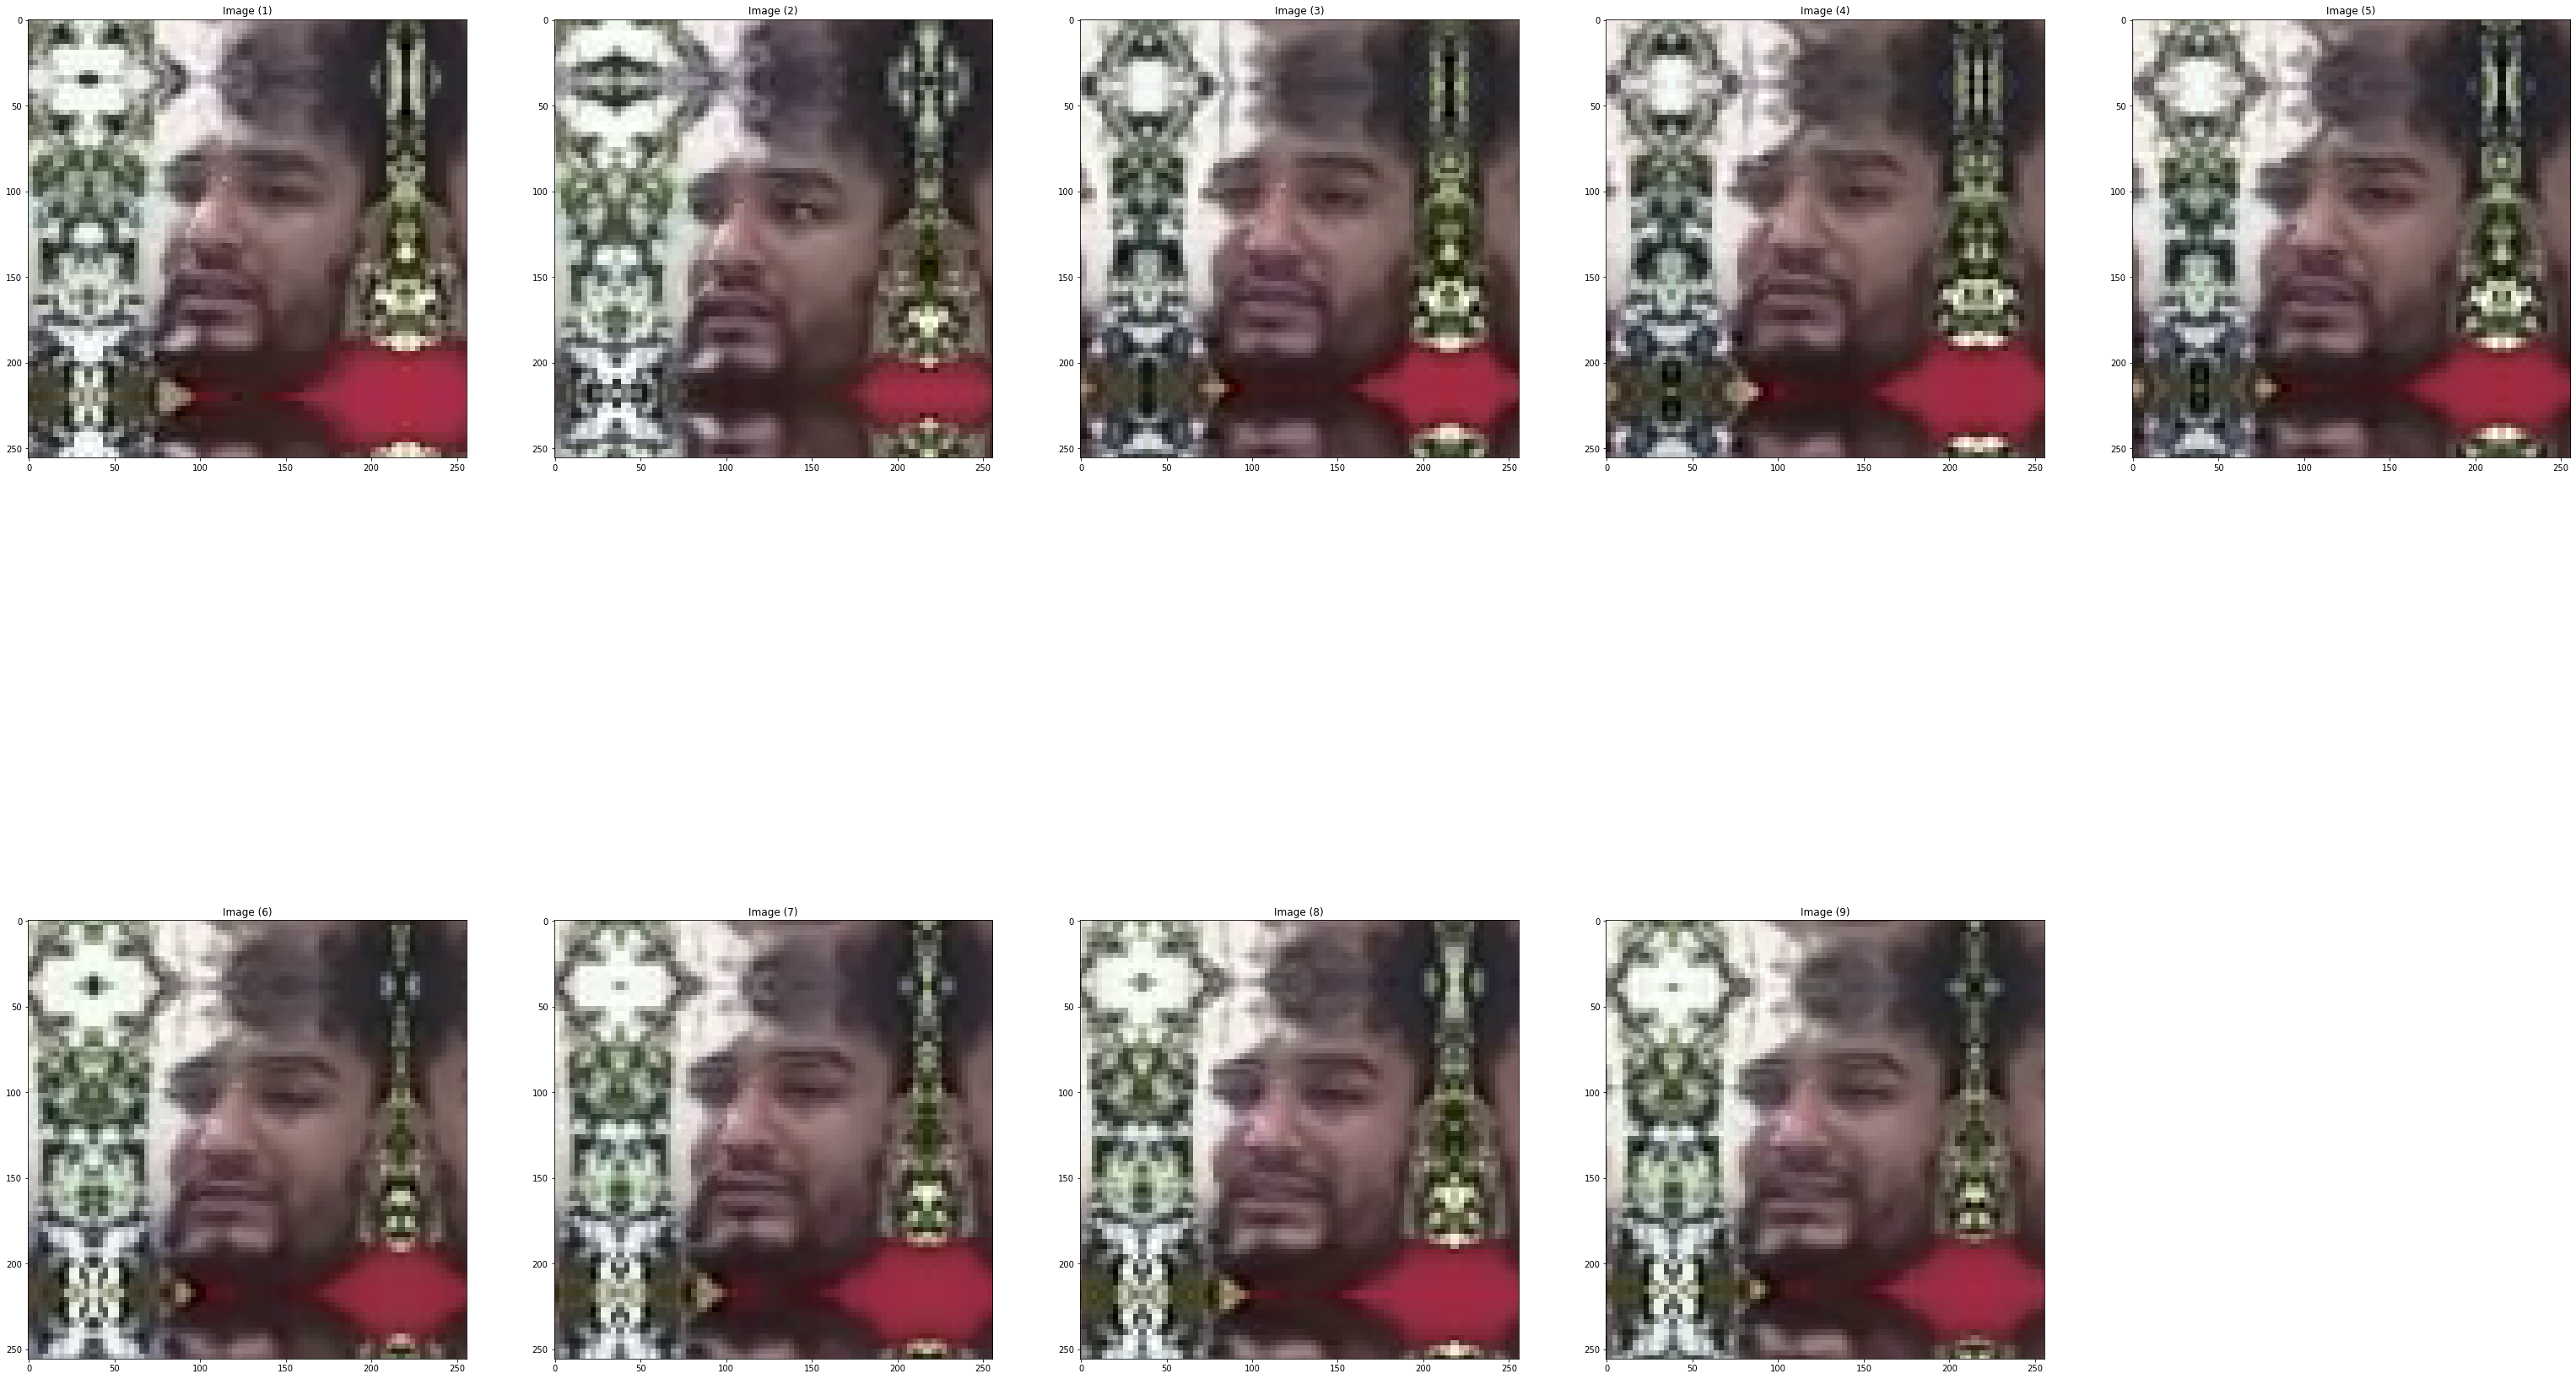

In [27]:
file = os.path.join(VID_DIR, 'dfdc_train_part_32/euqgbqurns.mp4')

min_size = 64

frames = read_frames_cv2(file, 10)
frames = torch.from_numpy(frames).to(device)
faces = find_faces(frames, detector, device, face_det_conf)
if min_size is not None:
    faces = filter(
        lambda x: x.shape[-1] < min_size and x.shape[-2] < min_size,
        faces)
faces = torch.stack(list(map(transforms, faces)))
images = faces.permute(0, 2, 3, 1).cpu().numpy()

show_images(images, cols=2)

In [19]:
mean = np.array([0.0] * 3)
std = np.array([0.0] * 3)
i = 0
min_size = 128

for file in tqdm(files):
    frames = read_frames_cv2(file, 10)
    frames = torch.from_numpy(frames).to(device)
    faces = find_faces(frames, detector, device, face_det_conf)
    if min_size is not None:
        faces = filter(
            lambda x: x.shape[-1] >= min_size and x.shape[-2] >= min_size,
            faces)
    faces = list(map(transforms, faces))
    print(len(faces))
    break
    del frames
    
    for f in faces:
        i += 1
        m, s = f.mean(dim=(1, 2)), f.std(dim=(1,2))
        for c in range(3):
            mean[c] += m[c].item()
            std[c] += s[c].item()

10


In [20]:
mean/i, std/i

/home/dmitry/anaconda3/envs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(array([nan, nan, nan]), array([nan, nan, nan]))

In [21]:
faces[0].shape

torch.Size([3, 256, 256])

In [22]:
i = 3

In [23]:
i += 1

10 256.0 256.0



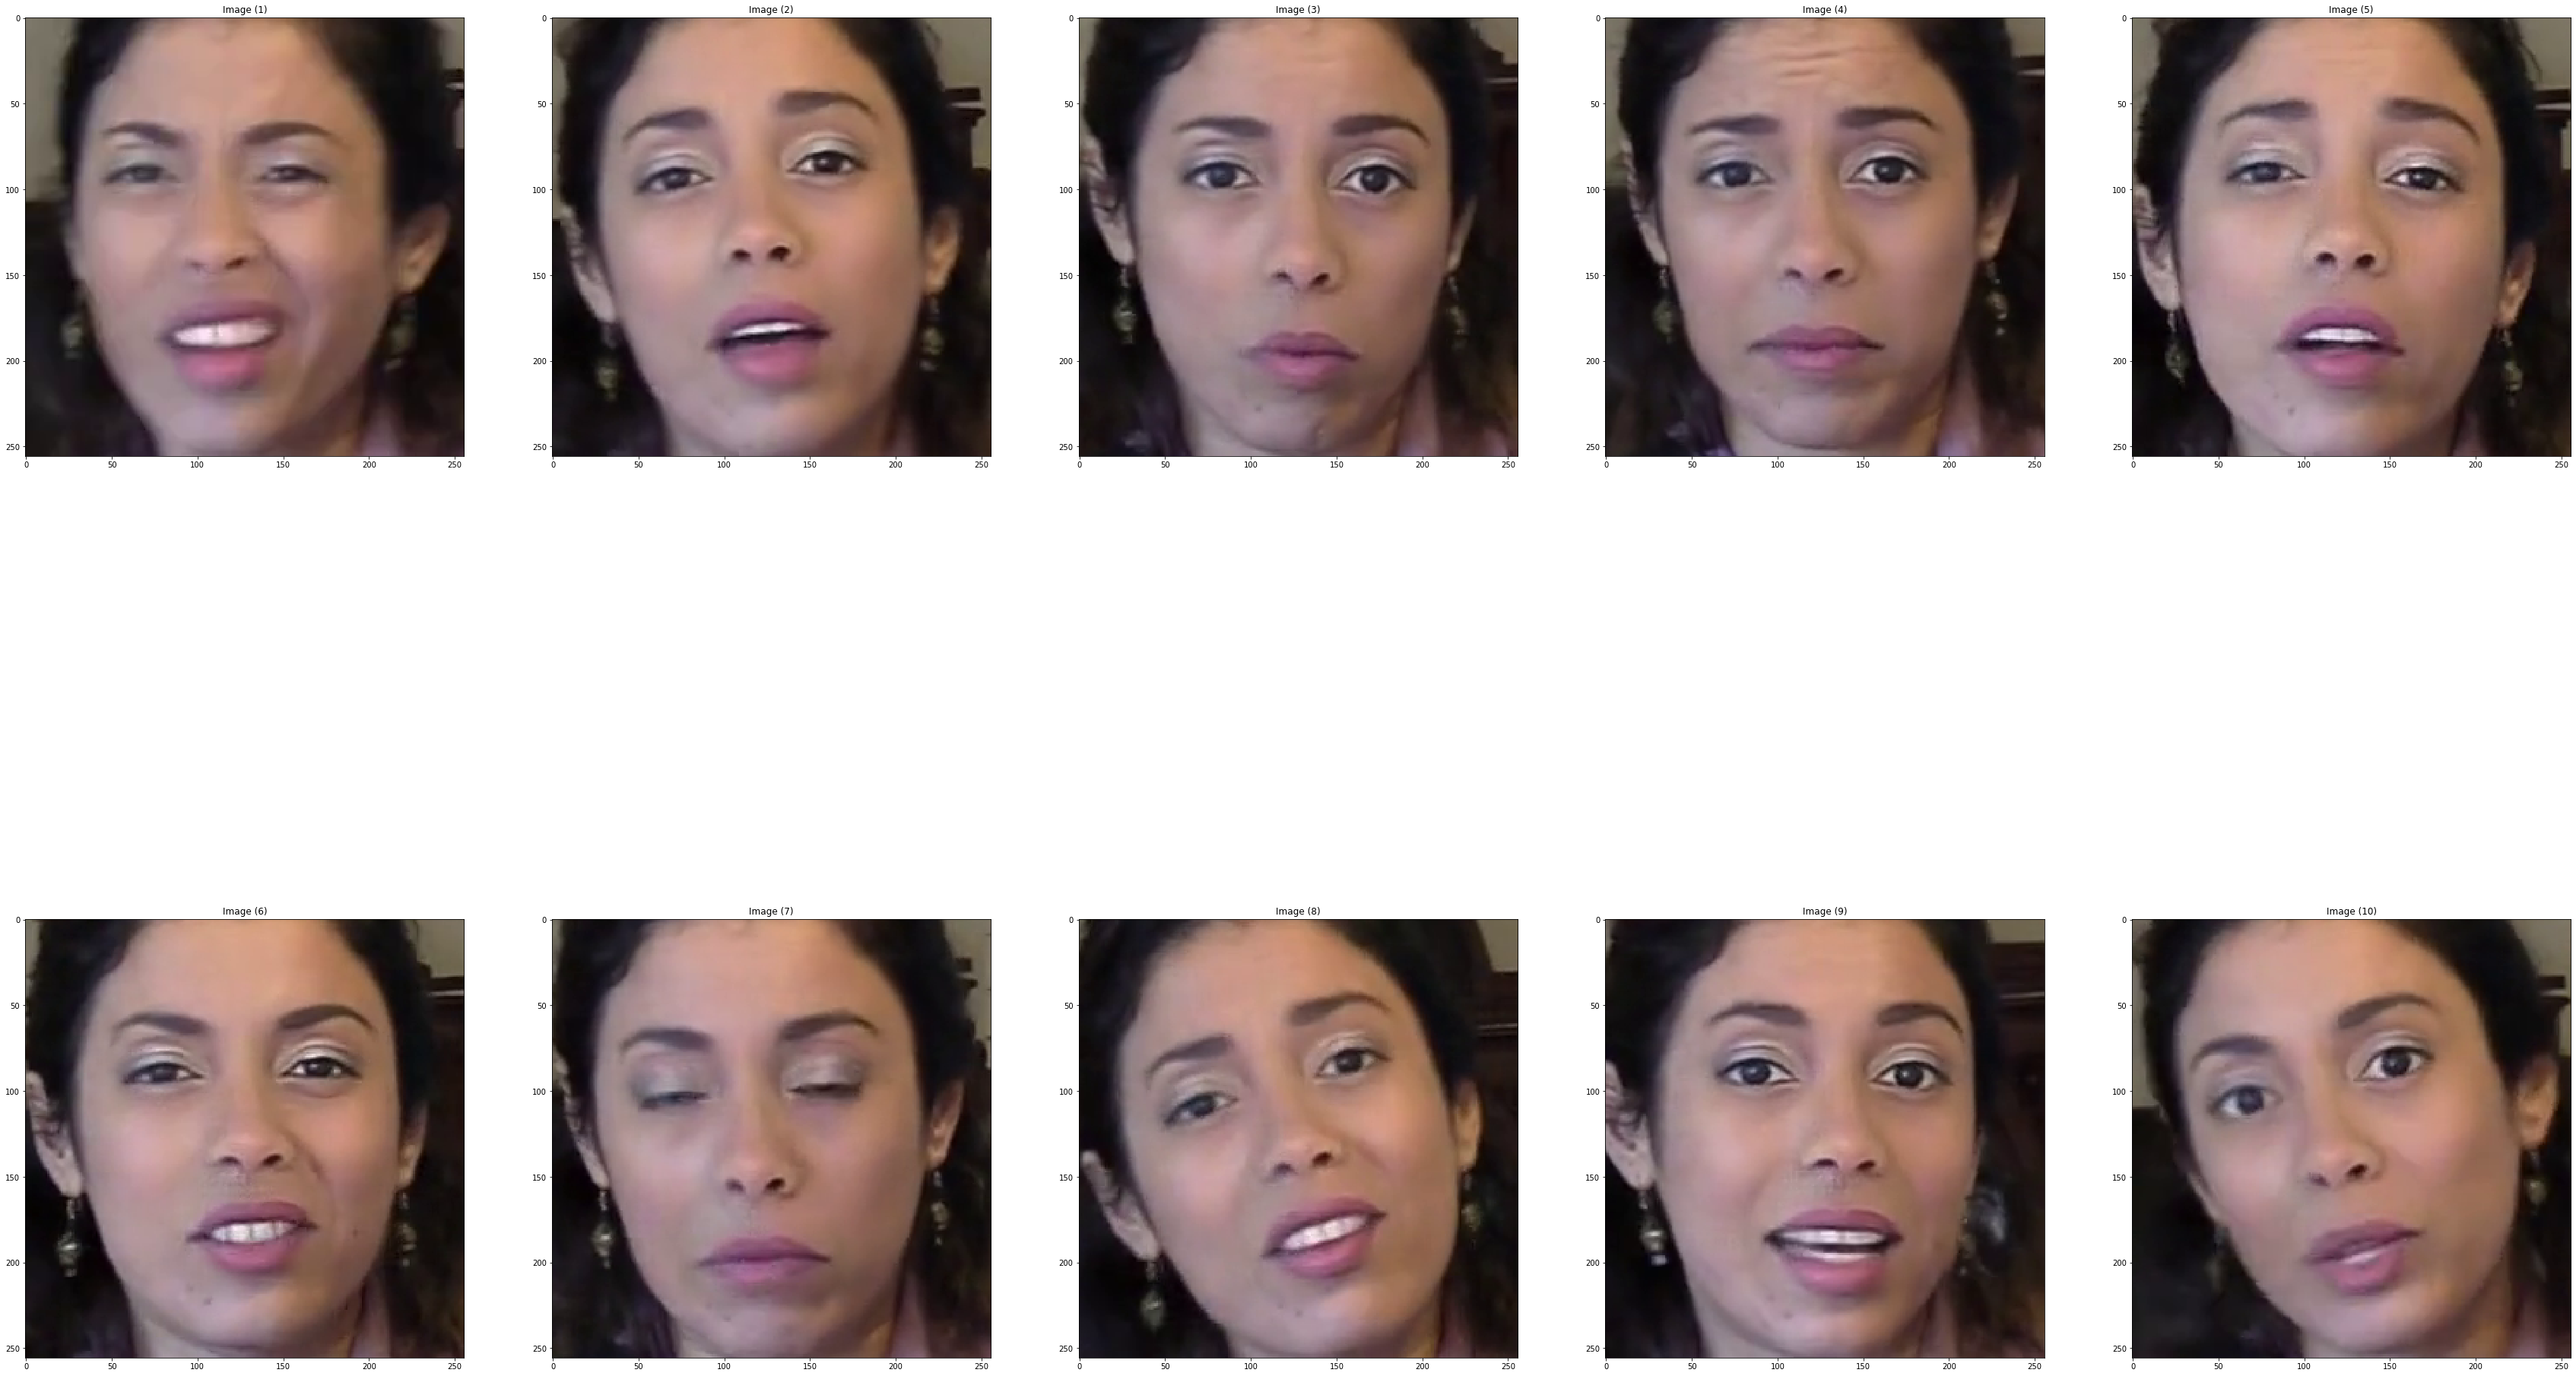

In [24]:
min_size = 128

file = files[i]
frames = read_frames_cv2(file, 10)
frames = torch.from_numpy(frames).to(device)
faces = find_faces(frames, detector, device, face_det_conf)

if min_size is not None:
    faces = filter(
        lambda x: x.shape[-1] >= min_size and x.shape[-2] >= min_size,
        faces)
faces = list(map(transforms, faces))
    
h, w = 0, 0
for f in faces:
    h += f.size(-2)
    w += f.size(-1)
l = max(len(faces), 1)
h /= l
w /= l
print(l, h, w)
i += 1

show_images([c.cpu().permute(1,2,0) for c in faces], cols=2)